<font face="calibri">
<font size = 5>
<c> <b> Convolutionally Recursive Convolutional Networks </b> </c>
</font>

This notebook is just fucking around with the toy CIFAR dataset - Relu of Relu's
<ulist>
<li> simplified the composite sigmoid function to just relu's with scale and shift parameters. </li>
<li> changed to backprop gradient directly into first forward pass </li>
</ulist>
</font>

In [1]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from import_stanford_dogs import load_dogs
import cv2
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from PIL import Image
import matplotlib.gridspec as gridspec
import pyprind
import time
import itertools as it
from six.moves import cPickle
from cs231n.data_utils import load_CIFAR10
from cs231n.vis_utils import visualize_grid
import scipy.ndimage as spi
import skimage.morphology as skm

#MAGICKS
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
require("base/js/utils").load_extensions("latex_envs/latex_envs")

<IPython.core.display.Javascript object>


<center><b> The composite relu activation function </b></center>

$ f(a, b) = \dfrac{M(a)}{1 + e^{-(b - T(a))}} \rightarrow M(a)\text{max}(0, b + T(a)) \hspace{135mm} $

<i> where </i>


$ M(a) = \alpha_1 + \dfrac{\alpha_2}{1 + e^{-(a - \alpha_3) / \alpha_4}} \rightarrow \text{max}(0, \alpha_0a) \hspace{147mm} $

$ T(a) = \beta_1 + \dfrac{\beta_2}{1 + e^{-(a - \beta_3) / \beta_4}} \rightarrow \text{max}(0, \beta_0a) \hspace{150mm}$

In [3]:
#helper functions

def composite_relu(x_a, x_b, a0, b0, name):

    M = tf.nn.tanh(tf.mul(a0,x_a))
    T = tf.nn.tanh(tf.mul(b0, x_a))
    
    forward = tf.mul(M,  tf.nn.relu(tf.add(x_b, T)))
    
    tf.histogram_summary(name + '_scale', M)
    tf.histogram_summary(name + '_shift', T)
    return forward   

def conv(x, W):
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1],
                                 padding = 'SAME')

def conv_pad(x, W, d, h, w, z, p, stride = 2):

    pad = tf.constant(0.0, shape = [d, p, w, z])

    x = tf.concat(1, [pad, x, pad])


    pad = tf.constant(0.0, shape = [d, w + 2*p, p, z])
    x = tf.concat(2, [pad, x, pad] )

    return tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = 'VALID')


def var(size):
    return tf.Variable(tf.constant(0.1, shape=[size]))

def checkAccuracy(y, y_1, y_2 = None, y_3 = None):
    ''''''
    ''' y_ is the output of softmax, it's a dictionary of validation accuracys '''
    ''''''
    
    
    if y_2 == None:
        accuracy = 0
        predict = np.argmax(y_1, axis = 1)
        num_correct = np.sum(predict == np.argmax(y, axis = 1))
        accuracy = num_correct / float(len(y))
        return accuracy
    
    
    accuracy = np.zeros([3])
    i = 0
    for y_ in (y_1, y_2, y_3):
        predict = np.argmax(y_, axis = 1)
        num_correct = np.sum(predict == np.argmax(y, axis = 1))
        accuracy[i] = (num_correct / float(len(y)))
        i +=1       
   
    return accuracy

In [4]:
#let's reduce layers in scale
sess1 = tf.Session()

#fill in shape

batch_size = 250

H = 32
W = 32
hidden1_size = 32
hidden2_size = 32
hidden3_size = 16
hidden4_size = 16
fc1_size = 10

num_glimpses = 20

x = tf.placeholder("float", shape = [None, H, W, 3])
y_ = tf.placeholder("float", shape = [None, fc1_size])

with tf.variable_scope("convolution1"):
    
    W_conv1 = tf.Variable(tf.truncated_normal([3,3,3, hidden1_size], stddev = 0.01), name = 'W_conv1')
    b_conv1 = tf.Variable(tf.constant(0.01, shape=[hidden1_size]), name = 'b_conv1')
    W_back1 = tf.Variable(tf.truncated_normal([3,3, hidden2_size, hidden1_size], stddev = 0.01), 'W_back1')   
    
    h_conv1 = b_conv1 + conv_pad(x, W_conv1, batch_size, H, W, 3, 1)
    
    mean1, var1 = tf.nn.moments(h_conv1, axes = [0, 1, 2], keep_dims = False)
    eta1 = tf.Variable(tf.constant(0.0, shape = [hidden1_size]), name = 'eta1')
    gamma1 = tf.Variable(tf.constant(1.0, shape = [hidden1_size]), name = 'gamma1')
    etab1 = tf.Variable(tf.constant(0.0, shape = [hidden1_size]), name = 'etab1')
    gammab1 = tf.Variable(tf.constant(1.0, shape = [hidden1_size]), name = 'gammab1')
    
    
    h_conv1d = tf.nn.dropout(h_conv1, .5)
    h_conv1b = tf.nn.batch_normalization(h_conv1d, mean1, var1, eta1, gamma1, 1e-6)
    h_conv1a = tf.nn.relu(h_conv1b)


    W_conv2 = tf.Variable(tf.truncated_normal([3,3, hidden1_size, hidden2_size], stddev= 0.01), name = 'W_conv2')
    b_conv2 = tf.Variable(tf.constant(0.01, shape = [hidden2_size]), name = 'b_conv2')
    W_back2 = tf.Variable(tf.truncated_normal([3,3, hidden3_size, hidden2_size], stddev = 0.01), name = 'W_back2')
    
    h_conv2 = b_conv2 + conv_pad(h_conv1a, W_conv2, batch_size, H/2, W/2, hidden1_size, 1)

    mean2, var2 = tf.nn.moments(h_conv2, axes = [0, 1, 2], keep_dims = False)
    eta2 = tf.Variable(tf.constant(0.0, shape = [hidden2_size]), name = 'eta2')
    gamma2 = tf.Variable(tf.constant(1.0, shape = [hidden2_size]), name = 'gamma2')
    etab2 = tf.Variable(tf.constant(0.0, shape = [hidden2_size]), name = 'etab3')
    gammab2 = tf.Variable(tf.constant(1.0, shape = [hidden2_size]), name = 'gammab3')        
    
    
    h_conv2d = tf.nn.dropout(h_conv2, .5)
    h_conv2b = tf.nn.batch_normalization(h_conv2d, mean2, var2, eta2, gamma2, 1e-6)  
    h_conv2a = tf.nn.relu(h_conv2b)

    a0_1 = var(hidden1_size)
    b0_1 = var(hidden1_size)


    #conv 3
    W_conv3 = tf.Variable(tf.truncated_normal([3,3, hidden2_size, hidden3_size], stddev = 0.01), name = 'W_conv3')
    b_conv3 = tf.Variable(tf.constant(0.01, shape = [hidden3_size]), name = 'b_conv2')
    W_back3 = tf.Variable(tf.truncated_normal([3,3, hidden4_size, hidden3_size], stddev = 0.01), name = 'W_back3')

    h_conv3 = b_conv3 +  conv_pad(h_conv2a, W_conv3, batch_size, H/4, W/4, hidden2_size, 1)
    
    #batchnorm and dropout
    mean3, var3 = tf.nn.moments(h_conv3, axes = [0, 1, 2], keep_dims = False)
    eta3 = tf.Variable(tf.constant(0.0, shape = [hidden3_size]), name = 'eta3')
    gamma3 = tf.Variable(tf.constant(1.0, shape = [hidden3_size]), name = 'gamma3')
    etab3 = tf.Variable(tf.constant(0.0, shape = [hidden3_size]), name = 'etab3')
    gammab3 = tf.Variable(tf.constant(1.0, shape = [hidden3_size]), name = 'gammab3') 
    
    h_conv3d = tf.nn.dropout(h_conv3, .5)
    h_conv3b = tf.nn.batch_normalization(h_conv3d, mean3, var3, eta3, gamma3, 1e-6)      
    
    h_conv3a = tf.nn.relu(h_conv3b)

    a0_2 = var(hidden2_size)
    b0_2 = var(hidden2_size)


    W_conv4 = tf.Variable(tf.truncated_normal([3,3, hidden3_size, hidden4_size], stddev = 0.01), name = 'W_conv3')
    b_conv4 = tf.Variable(tf.constant(0.01, shape = [hidden4_size]), name = 'b_conv2')
    W_back4 = tf.Variable(tf.truncated_normal([fc1_size, H/16*W/16*hidden4_size], stddev = 0.01), name = 'W_back4')

    #placeholder
    h_conv4 = b_conv4 +  conv_pad(h_conv3a, W_conv4, batch_size, H/8, W/8, hidden3_size, 1)
    
    mean4, var4 = tf.nn.moments(h_conv3, axes = [0, 1, 2], keep_dims = False)
    eta4 = tf.Variable(tf.constant(0.0, shape = [hidden4_size]), name = 'eta4')
    gamma4 = tf.Variable(tf.constant(1.0, shape = [hidden4_size]), name = 'gamma4')
    etab4 = tf.Variable(tf.constant(0.0, shape = [hidden4_size]), name = 'etab4')
    gammab4 = tf.Variable(tf.constant(1.0, shape = [hidden4_size]), name = 'gammab4') 
    
    
    h_conv4d = tf.nn.dropout(h_conv4, .5)
    h_conv4b = tf.nn.batch_normalization(h_conv4d, mean4, var4, eta4, gamma4, 1e-6)     
       
    h_conv4a = tf.nn.relu(h_conv4b)

    a0_3 = var(hidden3_size)
    b0_3 = var(hidden3_size)

    #FC 1
    W_fc1 = tf.Variable(tf.truncated_normal([H/16*W/16*hidden4_size, fc1_size], stddev = 0.01), name = 'W_fc1')
    b_fc1 = tf.Variable(tf.constant(0.01, shape = [fc1_size]), name = 'b_fc1')

    fc_reshape = tf.reshape(h_conv4a, [-1, H/16*W/16*hidden4_size])

    fc_out = b_fc1 + tf.matmul(fc_reshape, W_fc1)
    
    a0_4 = var(hidden4_size)
    b0_4 = var(hidden4_size)
    
with tf.variable_scope('loss'):
    
    softmax = {}
    cross_entropy = tf.Variable(0.0)
    softmax[0] = tf.nn.softmax(fc_out)
    cross_entropy += -(.05)*tf.reduce_sum(y_*tf.log(softmax[0]))
 
for i in xrange(1, num_glimpses):
    with tf.variable_scope('pass_'+str(i)):
        h_conv1 = b_conv1 + conv_pad(x, W_conv1, batch_size, H, W, 3, 1)

        back21 = conv_pad(h_conv2, W_back1, batch_size, H/4, H/4, hidden2_size, 5, stride = 1)
        meanb1, varb1 = tf.nn.moments(back21, axes = [0, 1, 2], keep_dims = False)
        mean1, var1 = tf.nn.moments(h_conv1, axes = [0, 1, 2], keep_dims = False)
        
        back21d = tf.nn.dropout(back21, .5)
        h_conv1d = tf.nn.dropout(h_conv1, .5)
        h_conv1b = tf.nn.batch_normalization(h_conv1d, mean1, var1, eta1, gamma1, 1e-6)
        back21b = tf.nn.batch_normalization(back21d, meanb1, varb1, etab1, gammab1, 1e-6)
        h_out1 = composite_relu(back21b, h_conv1b, a0_1, b0_1, 'h_out1_pass'+str(i))
            
        
        h_conv2 = b_conv2 + conv_pad(h_out1, W_conv2, batch_size, H/2, W/2, hidden1_size, 1)
        back32 = conv_pad(h_conv3, W_back2, batch_size, H/8, H/8, hidden3_size, 3, stride = 1)
        meanb2, varb2 = tf.nn.moments(back32, axes = [0, 1, 2], keep_dims = False)
        mean2, var2 = tf.nn.moments(h_conv2, axes = [0, 1, 2], keep_dims = False)
        
        h_conv2d = tf.nn.dropout(h_conv2, .5)
        back32d = tf.nn.dropout(back32, .5)
        
        h_conv2b = tf.nn.batch_normalization(h_conv2d, mean2, var2, eta2, gamma2, 1e-6)
        back32b = tf.nn.batch_normalization(back32d, meanb2, varb2, etab2, gammab2, 1e-6)
        
        h_out2 = composite_relu(back32b, h_conv2b, a0_2, b0_2, 'h_out2_pass' + str(i))
        

        h_conv3 = b_conv3 +  conv_pad(h_out2, W_conv3, batch_size, H/4, W/4, hidden2_size, 1)
        back43 = conv_pad(h_conv4, W_back3, batch_size, H/16, W/16, hidden4_size, 2, stride = 1)
      
        meanb3, varb3 = tf.nn.moments(back43, axes = [0, 1, 2], keep_dims = False)
        mean3, var3 = tf.nn.moments(h_conv3, axes = [0, 1, 2], keep_dims = False)
        
        h_conv3d = tf.nn.dropout(h_conv3, .5)
        back43d = tf.nn.dropout(back43, .5)
        
        h_conv3b = tf.nn.batch_normalization(h_conv3d, mean3, var3, eta3, gamma3, 1e-6)
        back43b = tf.nn.batch_normalization(back43d, meanb3, varb3, etab3, gammab3, 1e-6)
        
               
        h_out3 = composite_relu(back43b, h_conv3b, a0_3, b0_3, 'hout_3_pass' + str(i))
        
        h_conv4 = b_conv4 +  conv_pad(h_out3, W_conv4, batch_size, H/8, W/8, hidden3_size, 1)
        back_fc = tf.reshape(tf.matmul(fc_out, W_back4), shape = [-1, H/16, W/16, hidden4_size])

        meanb4, varb4 = tf.nn.moments(back_fc, axes = [0, 1, 2], keep_dims = False)
        mean4, var4 = tf.nn.moments(h_conv4, axes = [0, 1, 2], keep_dims = False)
        
        h_conv4d = tf.nn.dropout(h_conv4, .5)
        back_fcd = tf.nn.dropout(back_fc, .5)
        
        h_conv4b = tf.nn.batch_normalization(h_conv4d, mean4, var4, eta4, gamma4, 1e-6)
        back_fcb = tf.nn.batch_normalization(back_fcd, meanb4, varb4, etab4, gammab4, 1e-6)
        
        
        h_out4 = composite_relu(back_fcb, h_conv4b, a0_4, b0_4, 'hout_4_pass' + str(i))
        fc_reshape = tf.reshape(h_out4, [-1, H/16*W/16*hidden4_size])

        fc_out = b_fc1 + tf.matmul(fc_reshape, W_fc1)
        
        with tf.variable_scope('loss'):

            softmax[i] = tf.nn.softmax(fc_out)
            cross_entropy += -(.05*i)*tf.reduce_sum(y_*tf.log(softmax[i]))
            
cross_entropy += -tf.reduce_sum(y_*tf.log(softmax[i]))
                       
softmax_1 = softmax[0]

soft1 = tf.histogram_summary('softmax1', softmax_1)

softmax_2 = softmax[i]
soft2 = tf.histogram_summary('softmax2', softmax_2)


cross_entropy += 0.001*(tf.reduce_sum(tf.abs(back21b)) + tf.reduce_sum(tf.abs(back32b)) +
                tf.reduce_sum(tf.abs(back43b)) + tf.reduce_sum(tf.abs(back_fcb)))

lr = tf.Variable(tf.constant(1e-3))
lr_change = tf.assign(lr, tf.mul(.1, lr))

merged=tf.merge_all_summaries()
writer = tf.train.SummaryWriter("./logs", sess1.graph, flush_secs = 5)

train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

sess1.run(tf.initialize_all_variables())

In [5]:
#load the dataset
# Load the raw CIFAR-10 data
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
#now make it one hot
y_traino = np.zeros(shape = [len(y_train), 10])
#change the training labels to one hot encoding
for idx, val in enumerate(y_train):
    y_traino[idx, (val - 1)] = 1

y_testo = np.zeros(shape = [len(y_test), 10])
#change the testing labels to one hot encoding
for idx, val in enumerate(y_test):
    y_testo[idx, (val - 1)] = 1
  
y_valo = np.zeros(shape = [len(y_val), 10])
#change the validation labels to one hot encoding
for idx, val in enumerate(y_val):
    y_valo[idx, (val - 1)] = 1
  

In [7]:
y_train = y_traino
y_test = y_testo
y_val = y_valo


print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 10)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 10)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000, 10)


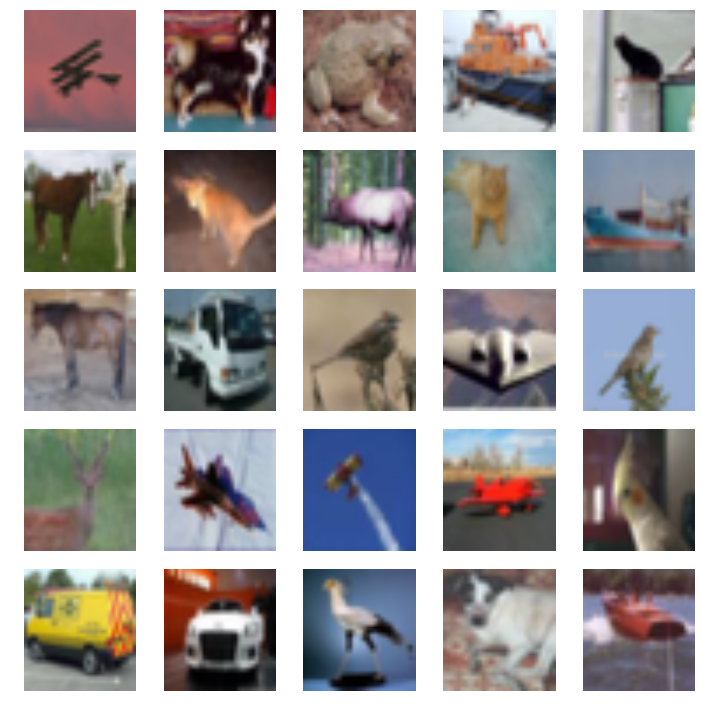

In [7]:
#visualize some training examples
num_rows = 5
num_cols = 5

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0)

ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
gs.update(hspace=0)
gs.tight_layout(fig, h_pad=0,w_pad=0)

for i,im in enumerate(X_train[np.random.randint(0, len(X_train), [num_rows*num_cols])].astype('uint8')):
    ax[i].imshow(im, aspect='auto')
    ax[i].axis('off')

plt.show()

#Mean subtracted data

In [8]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [ ]:
batch_size = 250
train_iter = 10000
loss_arr = []
accuracy_arr = []
validation_arr = []

bar = pyprind.ProgBar(train_iter, bar_char='█')

X_t = X_train
y_t = y_train
X_v = X_val
y_v = y_val

0%                          100%
[                              ]

In [ ]:
for i in xrange(0, train_iter):
    bar.update()
    batch_i = np.random.randint(0, len(X_t), [batch_size])
    X_batch = X_t[batch_i]
    y_batch = y_t[batch_i]
    
    summary_str, _, loss, s1, s2  = sess1.run([merged, train_step, cross_entropy, softmax_1, softmax_2], feed_dict = {x: X_batch, y_: y_batch})
    
    loss_arr.append(loss)
    
    s3  = np.zeros_like(s2)
    
    accuracy = checkAccuracy(y_batch, s1, s2, s3)
    accuracy_arr.append(accuracy)
    
    
    writer.add_summary(summary_str, i)
    writer.flush()
    #saver.save(sess, 'RNN_model.ckpt', global_step = i)
    if i % 10 == 0:
        ind = np.random.randint(0, len(X_v), [batch_size])

        s1, s2 = sess1.run([softmax_1, softmax_2], feed_dict = {x: X_v[ind], y_: y_v[ind]})
        
        s3 = np.zeros_like(s2)

        v_acc = checkAccuracy(y_v[ind], s1, s2, s3)
         
        validation_arr.append(v_acc)
        print "The validation accuracy is:", v_acc
    
    print "The loss is:", loss, "the training accuracy is:", accuracy[0:2]
    #if i % 500 == 0 and i > 0:
    #    sess.run(lr_change)
    

The validation accuracy is: [ 0.152  0.08   0.14 ]
The loss is: 7124.57 the training accuracy is: [ 0.108  0.128]
The loss is: 6971.5 the training accuracy is: [ 0.084  0.144]
The loss is: 7003.78 the training accuracy is: [ 0.108  0.136]
The loss is: 7006.93 the training accuracy is: [ 0.1    0.064]
The loss is: 6985.61 the training accuracy is: [ 0.12   0.084]
The loss is: 6908.77 the training accuracy is: [ 0.104  0.112]
The loss is: 6840.13 the training accuracy is: [ 0.12   0.068]
The loss is:

In [11]:
import seaborn as sns
sns.set(style = "white")
sns.despine()

plt.subplot(311);
plt.plot(loss_arr);
plt.subplot(312);
a = np.array(accuracy_arr)
b =  range(len(accuracy_arr))

plt.plot(b, a);


a = np.array(validation_arr)
b = range(len(validation_arr))

plt.subplot(313)
plt.plot(b, a)

#saver.restore(sess, "RNN_model.ckpt")

#idx = np.random.randint(0, N, [batch_size])

#print accuracy.eval(feed_dict={x: X_test[idx], y_: y_test[idx]}, session = sess)



[autoreload of tensorflow.python.ops.nn_grad failed: Traceback (most recent call last):
  File "/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
KeyError: "Registering two gradient with name 'Conv2DBackpropInput' !(Previous registration was in <module> /Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3)"
]
[autoreload of sklearn.preprocessing failed: Traceback (most recent call last):
  File "/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name MaxAbsScaler
]
[autoreload of sklearn.metrics.ranking failed: Traceback (most recent call last):
  File "/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_obj

ImportError: cannot import name stats

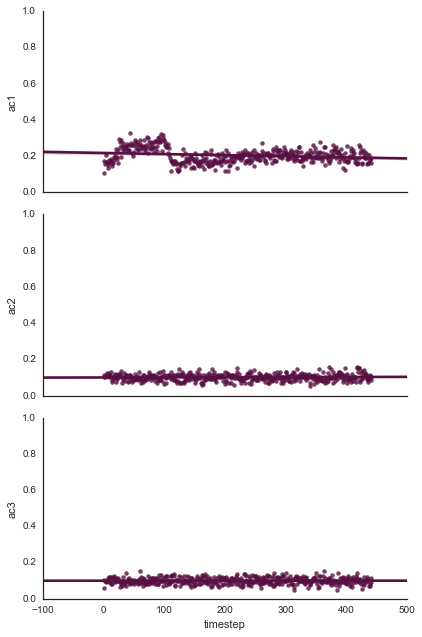

In [10]:
import seaborn as sns
sns.set(style = "white")
sns.despine()
import pandas as pd

a = {}

a['ac1'] = np.array(accuracy_arr)[:,0]
a['ac2'] = np.array(accuracy_arr)[:,1]
a['ac3'] = np.array(accuracy_arr)[:,2]
a['timestep'] = range(len(accuracy_arr))

a = pd.DataFrame(a)

g = sns.PairGrid(a, y_vars = ['ac1', 'ac2', 'ac3'], x_vars = ['timestep'], size = 3, aspect = 2)

g.map(sns.regplot, color=sns.xkcd_rgb["plum"])

g.set(ylim = (0, 1))

In [ ]:
def checkAccuracy(y, y_1, y_2, y_3):
    ''''''
    ''' y_ is the output of softmax, it's a dictionary of validation accuracys '''
    ''''''
    
    accuracy = np.zeros([3])
    i = 0
    for y_ in (y_1, y_2, y_3):
        predict = np.argmax(y_, axis = 1)
        num_correct = np.sum(predict == np.argmax(y, axis = 1))
        accuracy[i] = (num_correct / float(len(y)))
        i +=1 
   
    return accuracy

In [14]:
indx = np.random.randint(0, len(X_train), 250)

test_occl = np.zeros_like(X_test)
train_sub_occl = np.zeros_like(X_train[indx])
y_train_sub_occl = y_train[indx]

for a,img in enumerate(X_test):
    i = np.random.randint(4, 28, 8)
    j = np.random.randint(4, 28, 8)

    mask = np.zeros([32, 32])
    mask[i, j] = 1

    mask = spi.binary_dilation(mask, structure = skm.disk(radius = 6)).astype(mask.dtype)

    test_occl[a] = np.copy(img)

    test_occl[a][mask < 1] = mean_image[mask < 1]
    
    
for a,img in enumerate(X_train[indx]):
    i = np.random.randint(4, 28, 8)
    j = np.random.randint(4, 28, 8)

    mask = np.zeros([32, 32])
    mask[i, j] = 1

    mask = spi.binary_dilation(mask, structure = skm.disk(radius = 6)).astype(mask.dtype)

    test_occl[a] = np.copy(img)

    test_occl[a][mask < 1] = mean_image[mask < 1]

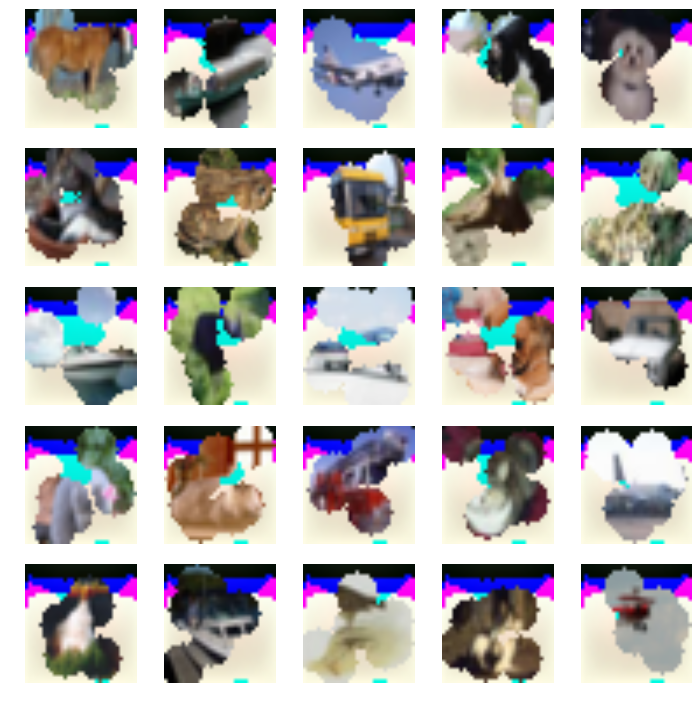

In [16]:
num_rows = 5
num_cols = 5

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0)

ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
gs.update(hspace=0)
gs.tight_layout(fig, h_pad=0,w_pad=0)

for i,im in enumerate(test_occl[np.random.randint(0, len(test_occl), [num_rows*num_cols])].astype('uint8')):
    ax[i].imshow((im + mean_image).astype('uint8'), aspect='auto')
    ax[i].axis('off')

plt.show()


In [24]:
indx = np.random.randint(0, len(test_occl), 250)

s1, s2 = sess1.run([softmax_1, softmax_2], feed_dict = {x: test_occl[indx], y_: y_test[indx]})

s3 = np.zeros_like(s2)

o_acc = checkAccuracy(y_test[indx], s1, s2, s3)

print "The test accuracy is:", o_acc

The test accuracy is: [ 0.208  0.312  0.076]


/Users/ameliachristensen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [10]:
X_batch.shape

NameError: name 'X_batch' is not defined